# 뉴스 편향성 분석 모델

이 노트북은 뉴스 기사의 민주당과 국힘에 대한 편향성을 분석하는 딥러닝 모델을 구현합니다.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 로드 및 전처리

In [3]:
# 베이스라인 결과 로드
baseline_results = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/baseline_results/baseline_results.csv').iloc[0]

In [4]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/정당_관점_라벨링_최종_업데이트.csv')  # 파일 경로는 실제 경로에 맞게 수정해주세요

# 정당 레이블 매핑
party_mapping = {'국민의힘': 0, '민주당': 1, '그외': 2}

# 정당 레이블 변환
df['party_label'] = df['party'].map(party_mapping)

# NaN 값 처리
df = df.dropna(subset=['title_cleaned', 'content_cleaned', 'party_label'])

# 제목과 본문 결합
df['text'] = df['title_cleaned'] + ' ' + df['content_cleaned']

print(f"전체 데이터 수: {len(df)}")
print("\n정당별 기사 수:")
print(df['party'].value_counts())
print("\n정당 레이블 분포:")
print(df['party_label'].value_counts())

전체 데이터 수: 1025

정당별 기사 수:
party
그외      430
민주당     320
국민의힘    275
Name: count, dtype: int64

정당 레이블 분포:
party_label
2    430
1    320
0    275
Name: count, dtype: int64


## 2. 데이터셋 클래스 정의

In [5]:
class NewsDataset(Dataset):
    def __init__(self, texts, party_labels, tokenizer, max_length=512):
        self.texts = texts
        self.party_labels = party_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # 텐서 차원 조정
        input_ids = encoding['input_ids'].squeeze(0)  # [max_length]
        attention_mask = encoding['attention_mask'].squeeze(0)  # [max_length]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'party_label': torch.tensor(self.party_labels[idx], dtype=torch.long)
        }

## 3. 모델 정의

In [6]:
class NewsBiasModel(torch.nn.Module):
    def __init__(self, model_name, num_party_labels=3, class_weights=None,
                 dropout_rate=0.2, hidden_size=512):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.register_buffer("class_weights", torch.tensor(class_weights, dtype=torch.float))

        # 드롭아웃 레이어
        self.dropout = torch.nn.Dropout(dropout_rate)

        # 특성 추출 레이어
        hidden_size_bert = self.bert.config.hidden_size
        self.feature_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden_size_bert, hidden_size),
            torch.nn.LayerNorm(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate)
        )

        # BiLSTM 레이어
        self.bilstm = torch.nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate+0.1
        )

        # 정당 분류기
        self.party_classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size // 2),
            torch.nn.LayerNorm(hidden_size // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(hidden_size // 2, num_party_labels)
        )

    def forward(self, input_ids, attention_mask, party_label=None):
        # BERT 출력
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # (batch_size, seq_len, 768)

        # 특성 추출
        features = self.dropout(sequence_output)
        features = self.feature_layer(features)  # (batch_size, seq_len, 384)

        # BiLSTM 적용
        lstm_output, _ = self.bilstm(features)  # (batch_size, seq_len, 768)

        # 최종 특성 추출 (평균 풀링)
        final_features = torch.mean(lstm_output, dim=1)  # (batch_size, 768)

        # 정당 예측
        party_logits = self.party_classifier(final_features)  # (batch_size, num_party_labels)

        if party_label is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            party_loss = loss_fct(party_logits, party_label)
            return {'loss': party_loss, 'party_logits': party_logits}

        return {'party_logits': party_logits}

## 4. 학습 준비

In [7]:
# 데이터 분할
train_texts, val_texts, train_party_labels, val_party_labels = train_test_split(
    df['text'].values,
    df['party_label'].values,
    test_size=0.1,
    random_state=42
)

In [8]:
# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

# 데이터셋 생성
train_dataset = NewsDataset(train_texts, train_party_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_party_labels, tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [9]:
label_list = [example['party_label'] for example in train_dataset]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),  # 0: 국민의힘, 1: 민주당, 2: 그외
    y=np.array(label_list)
)
print("클래스 가중치:", class_weights)

클래스 가중치: [1.29131653 1.05612829 0.78201866]


In [10]:
# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화 및 GPU 이동을 분리
model = NewsBiasModel('klue/roberta-base', class_weights=class_weights)
model = model.to(device)

# 커스텀 데이터 콜레이터
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


In [11]:
def compute_metrics(eval_pred):
    party_preds = eval_pred.predictions
    party_labels = eval_pred.label_ids

    party_preds = np.argmax(party_preds, axis=1)

    party_report = classification_report(
        party_labels,
        party_preds,
        target_names=['국민의힘', '민주당', '그외'],
        output_dict=True,
        zero_division=0
    )

    return {
        'party_f1': party_report['weighted avg']['f1-score'],
        'party_accuracy': party_report['accuracy'],
    }

In [12]:
# 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./news_bias_results',  # 디렉토리 이름 변경
    num_train_epochs=9,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3.3541e-05,
    warmup_ratio=0.1135,
    weight_decay=0.0256,
    logging_dir='./news_bias_logs',  # 로그 디렉토리 이름 변경
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='party_f1',  # 평가 메트릭 이름 변경
    gradient_accumulation_steps=3,  # 그래디언트 누적
    max_grad_norm=0.7155,  # 그래디언트 클리핑
    fp16=True,  # 혼합 정밀도 학습
    label_smoothing_factor=0.0672,  # 레이블 스무딩
    optim='adamw_torch',  # AdamW 옵티마이저 사용
    lr_scheduler_type='cosine'
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## 5. 학습 및 평가

In [13]:
# 학습 실행
trainer.train()

# 최종 평가
final_metrics = trainer.evaluate()
print("\n최종 평가 결과:")
print(f"정당 분류 F1 점수: {final_metrics['eval_party_f1']:.4f}")
print(f"정당 분류 정확도: {final_metrics['eval_party_accuracy']:.4f}")

Epoch,Training Loss,Validation Loss,Party F1,Party Accuracy
1,No log,1.050240,0.375853,0.456311
2,No log,0.791613,0.629136,0.621359
3,No log,0.761289,0.688932,0.689320
4,No log,0.730552,0.683265,0.679612
5,No log,0.748037,0.658279,0.660194
6,No log,0.770988,0.699979,0.699029
7,No log,0.763914,0.693588,0.689320
8,No log,0.777885,0.737759,0.737864
9,No log,0.773456,0.737795,0.737864



최종 평가 결과:
정당 분류 F1 점수: 0.7378
정당 분류 정확도: 0.7379


In [14]:
# 베이스라인과 성능 비교
comparison_results = {
    'Model': ['Baseline', 'News Bias BERT'],  # 모델 이름 변경
    'Party F1': [baseline_results['party_f1'], final_metrics['eval_party_f1']],  # 메트릭 이름 변경
    'Party Accuracy': [baseline_results['party_accuracy'], final_metrics['eval_party_accuracy']],  # 메트릭 이름 변경
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('./news_bias_results/model_comparison.csv', index=False)  # 저장 경로 변경
comparison_df.head()

,Model,Party F1,Party Accuracy
0,Baseline,0.640569,0.643902
1,News Bias BERT,0.737795,0.737864


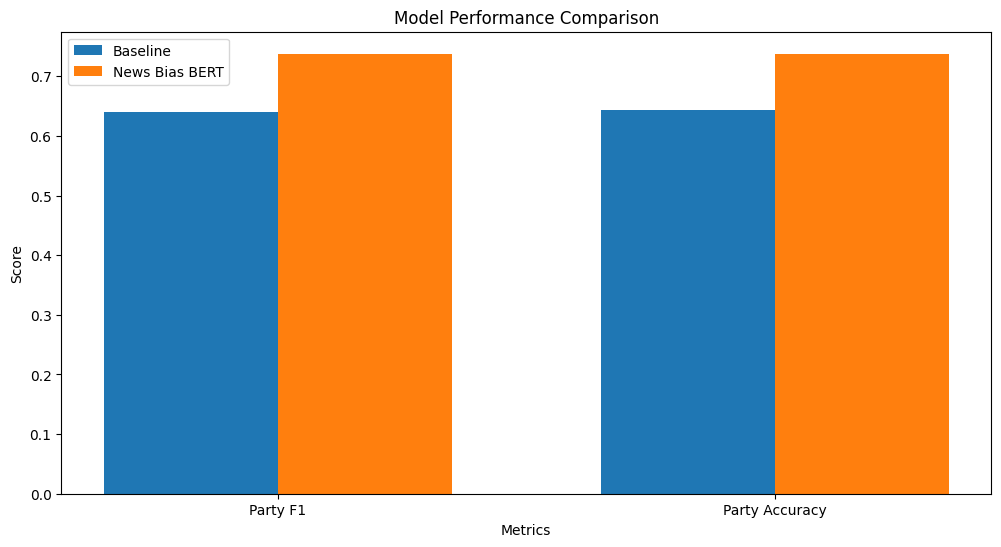

In [15]:
# 성능 향상 시각화
plt.figure(figsize=(12, 6))
metrics = ['Party F1', 'Party Accuracy']  # 메트릭 이름 변경
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison_df.iloc[0, 1:], width, label='Baseline')
plt.bar(x + width/2, comparison_df.iloc[1, 1:], width, label='News Bias BERT')  # 모델 이름 변경

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()

plt.savefig('./news_bias_results/performance_comparison.png')  # 저장 경로 변경
plt.show()

## 6. 하이퍼파라미터 튜닝

In [ ]:
!pip install optuna
!pip install optuna-integration[pytorch_lightning]  # 설치 후 세션을 다시 시작해야 함

In [15]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from sklearn.model_selection import KFold

In [23]:
def objective(trial):
    # 하이퍼파라미터 정의
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 0.01, 0.04),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.3),
        'hidden_size': trial.suggest_categorical('hidden_size', [256, 384, 512, 768, 1024]),
        'num_epochs': trial.suggest_int('num_epochs', 5, 15),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'warmup_ratio': trial.suggest_float('warmup_ratio', 0.1, 0.2),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.05, 0.10),
        'gradient_accumulation_steps': trial.suggest_int('gradient_accumulation_steps', 1, 4),
        'max_grad_norm': trial.suggest_float('max_grad_norm', 0.5, 1.0)
    }

    # K-fold 교차 검증
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # 데이터 분할
        train_texts = df.iloc[train_idx]['text'].values
        val_texts = df.iloc[val_idx]['text'].values
        train_labels = df.iloc[train_idx]['party_label'].values
        val_labels = df.iloc[val_idx]['party_label'].values

        # 데이터셋 생성
        train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
        val_dataset = NewsDataset(val_texts, val_labels, tokenizer)

        # 모델 초기화
        model = NewsBiasModel(
            'klue/roberta-base',
            class_weights=class_weights,
            dropout_rate=params['dropout_rate'],
            hidden_size=params['hidden_size']
        )
        model = model.to(device)

        # 학습 인자 설정
        training_args = TrainingArguments(
            output_dir='./temp_results',
            num_train_epochs=params['num_epochs'],
            per_device_train_batch_size=params['batch_size'],
            per_device_eval_batch_size=params['batch_size'] * 2,
            learning_rate=params['learning_rate'],
            warmup_ratio=params['warmup_ratio'],
            weight_decay=params['weight_decay'],
            logging_dir='./temp_logs',
            logging_steps=100,
            eval_strategy='epoch',
            save_strategy='no',
            load_best_model_at_end=False,
            save_total_limit=0,
            metric_for_best_model='party_f1',
            gradient_accumulation_steps=params['gradient_accumulation_steps'],
            max_grad_norm=params['max_grad_norm'],
            fp16=True,
            label_smoothing_factor=params['label_smoothing'],
            optim='adamw_torch',
            lr_scheduler_type='cosine'
        )

        # 트레이너 초기화
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
            compute_metrics=compute_metrics,
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=3,
                    early_stopping_threshold=0.001
                )
            ]
        )

        # 학습
        trainer.train()

        # 평가
        metrics = trainer.evaluate()
        scores.append(metrics['eval_party_f1'])

    # 평균 F1 점수 반환
    return np.mean(scores)

In [ ]:
# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # 20회 시도

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [26]:
# 모든 trial의 결과를 DataFrame으로 저장
trials_df = study.trials_dataframe()
trials_df.to_csv('hyperparameter_trials.csv', index=False)
trials_df.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_gradient_accumulation_steps,params_hidden_size,params_label_smoothing,params_learning_rate,params_max_grad_norm,params_num_epochs,params_warmup_ratio,params_weight_decay,state
0,0,0.663819,2025-06-14 11:46:07.871629,2025-06-14 11:51:07.974238,0 days 00:05:00.102609,16,0.279187,1,384,0.065000,0.000015,0.659867,12,0.163519,0.033839,COMPLETE
1,1,0.569027,2025-06-14 11:51:07.975207,2025-06-14 11:58:06.066161,0 days 00:06:58.090954,16,0.158626,3,512,0.098760,0.000002,0.505384,13,0.154662,0.035720,COMPLETE
2,2,0.674118,2025-06-14 11:58:06.067150,2025-06-14 12:03:53.722856,0 days 00:05:47.655706,64,0.118109,4,768,0.073240,0.000029,0.503510,14,0.132069,0.020156,COMPLETE
3,3,0.692987,2025-06-14 12:03:53.723790,2025-06-14 12:06:50.511882,0 days 00:02:56.788092,32,0.260503,1,256,0.052638,0.000017,0.624953,6,0.167738,0.012483,COMPLETE
4,4,0.426354,2025-06-14 12:06:50.512778,2025-06-14 12:09:59.830864,0 days 00:03:09.318086,64,0.162907,1,256,0.054680,0.000002,0.777909,7,0.157970,0.038072,COMPLETE


In [27]:
print(trials_df.sort_values(by='value', ascending=False).iloc[0])

number                                                         3
value                                                   0.692987
datetime_start                        2025-06-14 12:03:53.723790
datetime_complete                     2025-06-14 12:06:50.511882
duration                                  0 days 00:02:56.788092
params_batch_size                                             32
params_dropout_rate                                     0.260503
params_gradient_accumulation_steps                             1
params_hidden_size                                           256
params_label_smoothing                                  0.052638
params_learning_rate                                    0.000017
params_max_grad_norm                                    0.624953
params_num_epochs                                              6
params_warmup_ratio                                     0.167738
params_weight_decay                                     0.012483
state                    

In [28]:
# 최적의 하이퍼파라미터로 모델 학습
best_params = trial.params

In [29]:
best_params

{'learning_rate': 1.676253496408822e-05,
 'weight_decay': 0.012483159054831302,
 'dropout_rate': 0.2605034927659957,
 'hidden_size': 256,
 'num_epochs': 6,
 'batch_size': 32,
 'warmup_ratio': 0.16773817701335603,
 'label_smoothing': 0.05263779406124121,
 'gradient_accumulation_steps': 1,
 'max_grad_norm': 0.6249529006556371}

## 7. 모델 저장 및 로드

In [24]:
# 모델 저장
trainer.save_model('./news_bias_model')  # 저장 경로 변경
tokenizer.save_pretrained('./news_bias_model')  # 저장 경로 변경

('./news_bias_model/tokenizer_config.json',
 './news_bias_model/special_tokens_map.json',
 './news_bias_model/vocab.txt',
 './news_bias_model/added_tokens.json',
 './news_bias_model/tokenizer.json')

## 8. 새로운 기사에 대한 예측

In [29]:
# 모델 로드
def load_model(model_path, class_weights):
    model = NewsBiasModel('klue/roberta-base', class_weights=class_weights)  # 모델 클래스 변경

    # safetensors 파일 로드
    from safetensors.torch import load_file
    model.load_state_dict(load_file(f'{model_path}/model.safetensors'))

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

In [17]:
def predict_news(text, model, tokenizer, device):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        party_pred = torch.argmax(outputs['party_logits'], dim=1).item()

    # 정당 레이블 매핑
    party_mapping = {0: '국민의힘', 1: '민주당', 2: '그외'}
    return party_mapping[party_pred]  # 숫자 레이블을 정당 이름으로 변환하여 반환

In [20]:
def predict_csv_file(csv_path, model, tokenizer, device):
    # CSV 파일 로드
    df = pd.read_csv(csv_path)

    # 예측 결과를 저장할 리스트
    party_predictions = []

    # 각 텍스트에 대해 예측 수행
    for text in tqdm(df['text'], desc="Predicting"):
        party_pred = predict_news(text, model, tokenizer, device)
        party_predictions.append(party_pred)

    # 예측 결과를 DataFrame에 추가
    df['party'] = party_predictions

    # # 결과 저장
    # output_path = csv_path.replace('.csv', '_predicted.csv')
    # df.to_csv(output_path, index=False)

    # 예측 결과 통계 출력
    print(f"\n{csv_path} 예측 결과:")
    print("\n정당 예측 분포:")
    print(df['party'].value_counts())

    return df

In [30]:
# 모델 로드
model, tokenizer = load_model('./news_bias_model', class_weights)  # 모델 경로 변경
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# CSV 파일 예측
csv_path = "/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체1.csv"  # 여기에 실제 CSV 파일 경로를 입력하시면 됩니다
predicted_df = predict_csv_file(csv_path, model, tokenizer, device)
predicted_df.head()

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(
Predicting: 100%|██████████| 3000/3000 [01:03<00:00, 47.42it/s]



/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체1.csv 예측 결과:

정당 예측 분포:
party
그외      1054
국민의힘    1030
민주당      916
Name: count, dtype: int64


,title_cleaned,content_cleaned,text,press,url,created_date,modified_date,journalist,comment_count,related_titles,related_urls,party
0,부산이 나라 구해 달라투표율 주목,이재명 민주당 상임 선대위원장은 낙동강 벨트가 있는 부산 울산 경남에서 지지를 호소...,부산이 나라 구해 달라 투표율 주목 이재명 민주당 상임 선대위원장은 낙동강 벨트가 ...,SBS,https://n.news.naver.com/mnews/article/055/000...,2024.04.05. 오전 12:48,2024.04.05. 오전 12:50,한소희 기자,26,"진실 알려주자 시민 '경악'…10만 명 시청 생중계 실체|""이 돈 주고 분양받다니…...",https://news.sbs.co.kr/news/endPage.do?news_id...,국민의힘
1,이재명 감세론으로 우클릭친노·친문 제동에도 노선 변화 밀어붙이나,인터뷰를 인용보도할 때는 프로그램명 을 정확히 밝혀주시기 바랍니다 저작권은 에 있...,이재명 감세론 으로 우클릭 친노 친문 제동에도 노선 변화 밀어붙이나 인터뷰를 인용보...,SBS,https://n.news.naver.com/mnews/article/055/000...,2024.07.15. 오후 3:41,2024.07.15. 오후 3:59,NaN,0,"""몸 날렸다"" 아내와 딸 지키다…총격에 숨진 트럼프 지지자|후배들 비판 묻자 옅게 ...",https://news.sbs.co.kr/news/endPage.do?news_id...,민주당
2,민주 영수회담 민생 해결·국정 전환 첫걸음 돼야,더불어민주당 박성준 대변인 민주당은 윤석열 대통령과 이재명 대표의 영수회담을 하루 ...,민주 영수회담 민생 해결 국정 전환 첫걸음 돼야 더불어민주당 박성준 대변인 민주당은...,SBS,https://n.news.naver.com/mnews/article/055/000...,2024.04.28. 오후 5:27,2024.04.28. 오후 5:29,한소희 기자,0,"칠흑같은 하늘에 빨려들어갔다…중 덮친 토네이도 영상|""살인 자백하면 감형?"" 신고 ...",https://news.sbs.co.kr/news/endPage.do?news_id...,민주당
3,공수처 구치소 방문해 윤 대통령 강제구인 시도중···검찰 공수처에 사건 송부 협의 요청,고위공직자범죄수사처 수사팀이 탄 차량이 20일 윤 대통령이 수용돼 있는 경기 의왕시...,공수처 구치소 방문해 윤 대통령 강제구인 시도중 검찰 공수처에 사건 송부 협의 요청...,경향신문,https://n.news.naver.com/mnews/article/032/000...,2025.01.20. 오후 6:18,2025.01.20. 오후 9:13,정대연 외 2명,15,"""김성훈, '김건희에 맛난 회 준다' 바다에 가두리 만들어 작살 사냥"" 황제경호 논...",https://www.khan.co.kr/article/202501201504001...,국민의힘
4,쓰레기 선거를 녹색선거로 바꾸기 위한 방법,녹색정의당 탄소중립 선거를 위한 공직선거법 개정 공약 발표 마포을에 출마한 장혜영...,쓰레기 선거 를 녹색선거 로 바꾸기 위한 방법 녹색정의당 탄소중립 선거를 위한 공직...,오마이뉴스,https://n.news.naver.com/mnews/article/047/000...,2024.03.22. 오후 12:03,2024.03.22. 오후 1:19,NaN,3,"노무현의 당부... 민주당과 조국혁신당이 놓치고 있는 것|미친 애호박 가격, 국수집...",https://www.ohmynews.com/NWS_Web/View/at_pg.as...,그외


In [33]:
# 저장
predicted_df.to_csv(csv_path, index=False)

## 2번째 시도

In [34]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체1.csv')  # 파일 경로는 실제 경로에 맞게 수정해주세요

# 정당 레이블 매핑
party_mapping = {'국민의힘': 0, '민주당': 1, '그외': 2}

# 정당 레이블 변환
df['party_label'] = df['party'].map(party_mapping)

# NaN 값 처리
df = df.dropna(subset=['title_cleaned', 'content_cleaned', 'party_label'])

# 제목과 본문 결합
df['text'] = df['title_cleaned'] + ' ' + df['content_cleaned']

print(f"전체 데이터 수: {len(df)}")
print("\n정당별 기사 수:")
print(df['party'].value_counts())
print("\n정당 레이블 분포:")
print(df['party_label'].value_counts())

전체 데이터 수: 3000

정당별 기사 수:
party
그외      1054
국민의힘    1030
민주당      916
Name: count, dtype: int64

정당 레이블 분포:
party_label
2    1054
0    1030
1     916
Name: count, dtype: int64


In [35]:
# 데이터 분할
train_texts, val_texts, train_party_labels, val_party_labels = train_test_split(
    df['text'].values,
    df['party_label'].values,
    test_size=0.1,
    random_state=42
)

In [36]:
# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

# 데이터셋 생성
train_dataset = NewsDataset(train_texts, train_party_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_party_labels, tokenizer)

In [37]:
label_list = [example['party_label'] for example in train_dataset]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),  # 0: 국민의힘, 1: 민주당, 2: 그외
    y=np.array(label_list)
)
print("클래스 가중치:", class_weights)

클래스 가중치: [0.97826087 1.08695652 0.94537815]


In [38]:
# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화 및 GPU 이동을 분리
model = NewsBiasModel('klue/roberta-base', class_weights=class_weights)
model = model.to(device)

# 커스텀 데이터 콜레이터
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


In [40]:
# 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./news_bias_results',  # 디렉토리 이름 변경
    num_train_epochs=9,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3.3541e-05,
    warmup_ratio=0.1135,
    weight_decay=0.0256,
    logging_dir='./news_bias_logs',  # 로그 디렉토리 이름 변경
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='party_f1',  # 평가 메트릭 이름 변경
    gradient_accumulation_steps=3,  # 그래디언트 누적
    max_grad_norm=0.7155,  # 그래디언트 클리핑
    fp16=True,  # 혼합 정밀도 학습
    label_smoothing_factor=0.0672,  # 레이블 스무딩
    optim='adamw_torch',  # AdamW 옵티마이저 사용
    lr_scheduler_type='cosine'
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [41]:
# 학습 실행
trainer.train()

# 최종 평가
final_metrics = trainer.evaluate()
print("\n최종 평가 결과:")
print(f"정당 분류 F1 점수: {final_metrics['eval_party_f1']:.4f}")
print(f"정당 분류 정확도: {final_metrics['eval_party_accuracy']:.4f}")

Epoch,Training Loss,Validation Loss,Party F1,Party Accuracy
1,No log,0.706679,0.673145,0.680000
2,No log,0.500551,0.821824,0.823333
3,No log,0.481027,0.812384,0.816667
4,0.532000,0.404371,0.856625,0.856667
5,0.532000,0.588556,0.816758,0.816667
6,0.532000,0.491254,0.856595,0.856667
7,0.090200,0.449803,0.863134,0.863333
8,0.090200,0.466839,0.866031,0.866667
9,0.090200,0.461260,0.872940,0.873333



최종 평가 결과:
정당 분류 F1 점수: 0.8729
정당 분류 정확도: 0.8733


In [42]:
# 베이스라인과 성능 비교
comparison_results = {
    'Model': ['Baseline', 'News Bias BERT'],  # 모델 이름 변경
    'Party F1': [baseline_results['party_f1'], final_metrics['eval_party_f1']],  # 메트릭 이름 변경
    'Party Accuracy': [baseline_results['party_accuracy'], final_metrics['eval_party_accuracy']],  # 메트릭 이름 변경
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('./news_bias_results/model_comparison.csv', index=False)  # 저장 경로 변경
comparison_df.head()

,Model,Party F1,Party Accuracy
0,Baseline,0.640569,0.643902
1,News Bias BERT,0.872940,0.873333


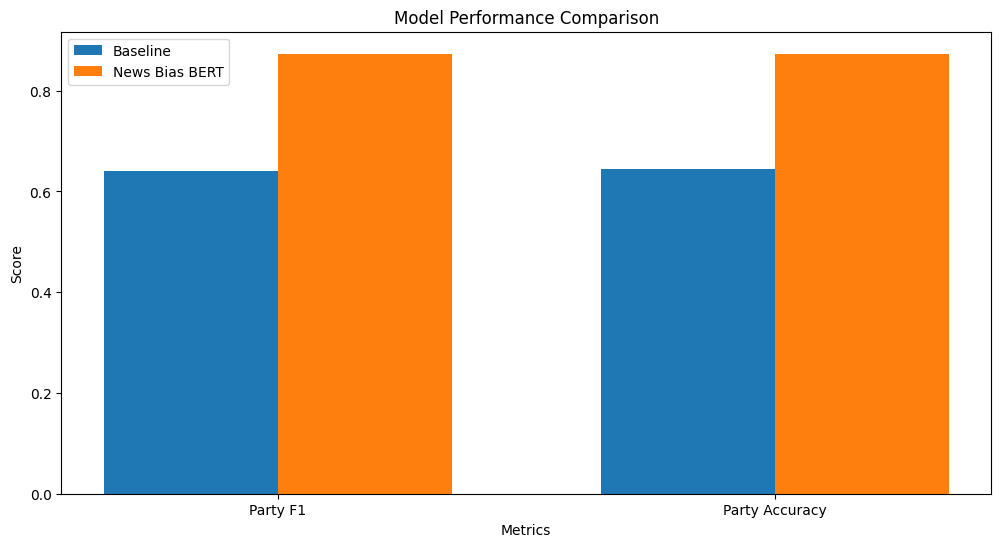

In [43]:
# 성능 향상 시각화
plt.figure(figsize=(12, 6))
metrics = ['Party F1', 'Party Accuracy']  # 메트릭 이름 변경
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison_df.iloc[0, 1:], width, label='Baseline')
plt.bar(x + width/2, comparison_df.iloc[1, 1:], width, label='News Bias BERT')  # 모델 이름 변경

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()

plt.savefig('./news_bias_results/performance_comparison.png')  # 저장 경로 변경
plt.show()

In [44]:
# 모델 저장
trainer.save_model('./news_bias_model')  # 저장 경로 변경
tokenizer.save_pretrained('./news_bias_model')  # 저장 경로 변경

('./news_bias_model/tokenizer_config.json',
 './news_bias_model/special_tokens_map.json',
 './news_bias_model/vocab.txt',
 './news_bias_model/added_tokens.json',
 './news_bias_model/tokenizer.json')

In [45]:
# 모델 로드
model, tokenizer = load_model('./news_bias_model', class_weights)  # 모델 경로 변경
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# CSV 파일 예측
csv_path = "/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체2.csv"  # 여기에 실제 CSV 파일 경로를 입력하시면 됩니다
predicted_df = predict_csv_file(csv_path, model, tokenizer, device)
predicted_df.head()

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(
Predicting: 100%|██████████| 5000/5000 [01:44<00:00, 48.01it/s]



/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체2.csv 예측 결과:

정당 예측 분포:
party
국민의힘    1883
그외      1639
민주당     1478
Name: count, dtype: int64


,title_cleaned,content_cleaned,text,press,url,created_date,modified_date,journalist,comment_count,related_titles,related_urls,party
0,국민의힘 오늘 당원투표·여론조사 종료마지막 지지 호소,국민의힘 당 대표 후보들 국민의힘이 오늘22일 새 지도부 선출을 위한 전당대회 투표...,국민의힘 오늘 당원투표 여론조사 종료 마지막 지지 호소 국민의힘 당 대표 후보들 국...,SBS,https://n.news.naver.com/mnews/article/055/000...,2024.07.22. 오전 8:08,2024.07.22. 오전 8:09,이성훈 기자,1,"피 묻은채 서있던 50대…""사장이 전여친"" 카페는 아수라장|""힘드시죠? 써보시길"" ...",https://news.sbs.co.kr/news/endPage.do?news_id...,그외
1,잠시 뒤 용산서 첫 영수회담민생·정국 현안 논의,윤석열 대통령과 이재명 민주당 대표의 영수회담이 잠시 뒤부터 용산 대통령실에서 열립...,잠시 뒤 용산서 첫 영수회담 민생 정국 현안 논의 윤석열 대통령과 이재명 민주당 대...,SBS,https://n.news.naver.com/mnews/article/055/000...,2024.04.29. 오후 2:08,2024.04.29. 오후 2:15,김기태 기자,1,"""아기는 어딨죠?"" 직원들 화들짝…1살 된 101살 승객 해프닝|'춤춘 게 죄?' ...",https://news.sbs.co.kr/news/endPage.do?news_id...,국민의힘
2,국회 앞 술병 장착 윤석열 탈 등장,국회 앞 술병 장착 윤석열 탈 등장 박수림 4일 국회가 윤석열 대통령이 선포한 비...,오마이포토 국회 앞 술병 장착 윤석열 탈 등장 국회 앞 술병 장착 윤석열 탈 등장 ...,오마이뉴스,https://n.news.naver.com/mnews/article/047/000...,2024.12.04. 오전 4:16,2024.12.04. 오전 4:21,박수림 기자,4,"국회 긴급 본회의, 190명 계엄령 해제 요구 의결|이재명 ""계엄령 선포, 절차적 ...",https://www.ohmynews.com/NWS_Web/View/at_pg.as...,민주당
3,민주당 사법개혁 변수 만들 때 아니다,대법원 견제 당위성에도 동시다발 법안 사법개혁 취지에 안 맞고 법리도 허점 정청래...,이충재의 인사이트 민주당 사법개혁 변수 만들 때 아니다 대법원 견제 당위성에도 동시...,오마이뉴스,https://n.news.naver.com/mnews/article/047/000...,2025.05.15. 오전 6:45,NaN,이충재 기자,49,"아직 ""긴가민가한"" 영남 보수층, '재매이' 에게 마음 열까|TK 이재명-김문수 지...",https://www.ohmynews.com/NWS_Web/View/at_pg.as...,그외
4,이재명 尹에게 김경수 복권 지속 요청 후보 많을수록 좋다,2021년 6월 17일 김경수왼쪽 당시 경남지사와 이재명 당시 경기지사가 경남 창원...,이재명 尹에게 김경수 복권 지속 요청 후보 많을수록 좋다 2021년 6월 17일 김...,한국일보,https://n.news.naver.com/mnews/article/469/000...,2024.08.10. 오후 7:22,2024.08.10. 오후 7:24,김정현 기자,0,"""일본 가도 되나요?"" 대지진 공포… 현지인도 ""일부러 오지 마세요""|제자 구하고 ...",https://www.hankookilbo.com/News/Read/A2024080...,민주당


In [46]:
# 저장
predicted_df.to_csv(csv_path, index=False)

## 3번째 시도

In [47]:
# 데이터 로드
df1 = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체2.csv')
df = pd.concat([df1, df2], ignore_index=True)

# 정당 레이블 매핑
party_mapping = {'국민의힘': 0, '민주당': 1, '그외': 2}

# 정당 레이블 변환
df['party_label'] = df['party'].map(party_mapping)

# NaN 값 처리
df = df.dropna(subset=['title_cleaned', 'content_cleaned', 'party_label'])

# 제목과 본문 결합
df['text'] = df['title_cleaned'] + ' ' + df['content_cleaned']

print(f"전체 데이터 수: {len(df)}")
print("\n정당별 기사 수:")
print(df['party'].value_counts())
print("\n정당 레이블 분포:")
print(df['party_label'].value_counts())

전체 데이터 수: 8000

정당별 기사 수:
party
국민의힘    2913
그외      2693
민주당     2394
Name: count, dtype: int64

정당 레이블 분포:
party_label
0    2913
2    2693
1    2394
Name: count, dtype: int64


클래스 가중치: [0.91498284 1.10650069 0.99667774]


Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Party F1,Party Accuracy
1,No log,0.345759,0.865467,0.866250
2,0.716100,0.264484,0.897671,0.897500
3,0.257500,0.283438,0.891434,0.891250
4,0.153400,0.383337,0.887491,0.886250
5,0.153400,0.315596,0.901204,0.901250
6,0.078500,0.390097,0.897615,0.897500
7,0.054600,0.348942,0.910106,0.910000
8,0.036900,0.369484,0.908785,0.908750
9,0.036900,0.387511,0.918745,0.918750
10,0.018600,0.395800,0.914969,0.915000



최종 평가 결과:
정당 분류 F1 점수: 0.9187
정당 분류 정확도: 0.9187


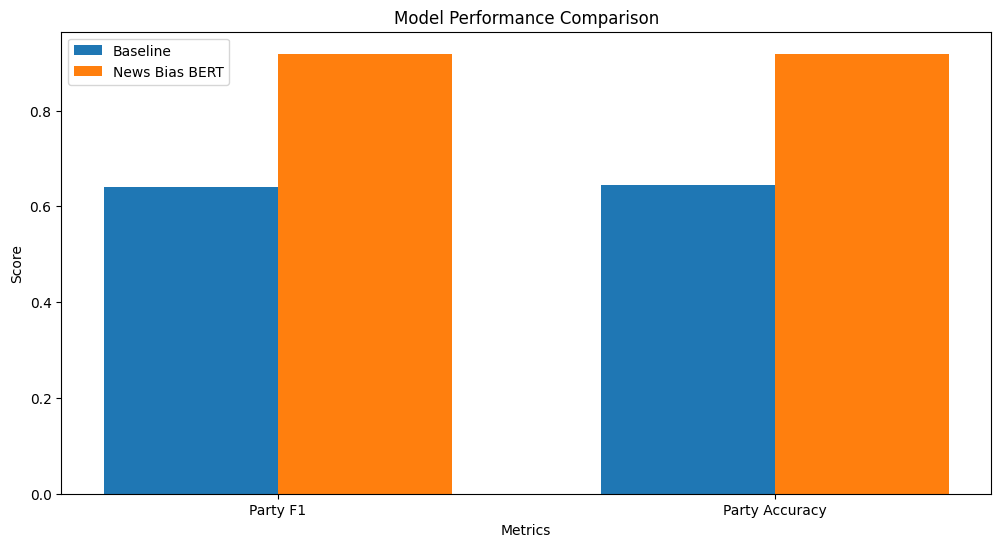

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(
Predicting: 100%|██████████| 78973/78973 [29:03<00:00, 45.30it/s]



/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체통합_전처리.csv 예측 결과:

정당 예측 분포:
party
국민의힘    30495
그외      25377
민주당     23101
Name: count, dtype: int64


In [48]:
# 데이터 분할
train_texts, val_texts, train_party_labels, val_party_labels = train_test_split(
    df['text'].values,
    df['party_label'].values,
    test_size=0.1,
    random_state=42
)

# 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')

# 데이터셋 생성
train_dataset = NewsDataset(train_texts, train_party_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_party_labels, tokenizer)

label_list = [example['party_label'] for example in train_dataset]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1, 2]),  # 0: 국민의힘, 1: 민주당, 2: 그외
    y=np.array(label_list)
)
print("클래스 가중치:", class_weights)

# 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화 및 GPU 이동을 분리
model = NewsBiasModel('klue/roberta-base', class_weights=class_weights)
model = model.to(device)

# 커스텀 데이터 콜레이터
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 학습 인자 설정
training_args = TrainingArguments(
    output_dir='./news_bias_results',  # 디렉토리 이름 변경
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=3.3541e-05,
    warmup_ratio=0.1135,
    weight_decay=0.0256,
    logging_dir='./news_bias_logs',  # 로그 디렉토리 이름 변경
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='party_f1',  # 평가 메트릭 이름 변경
    gradient_accumulation_steps=3,  # 그래디언트 누적
    max_grad_norm=0.7155,  # 그래디언트 클리핑
    fp16=True,  # 혼합 정밀도 학습
    label_smoothing_factor=0.0672,  # 레이블 스무딩
    optim='adamw_torch',  # AdamW 옵티마이저 사용
    lr_scheduler_type='cosine'
)

# 트레이너 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)

# 학습 실행
trainer.train()

# 최종 평가
final_metrics = trainer.evaluate()
print("\n최종 평가 결과:")
print(f"정당 분류 F1 점수: {final_metrics['eval_party_f1']:.4f}")
print(f"정당 분류 정확도: {final_metrics['eval_party_accuracy']:.4f}")

# 베이스라인과 성능 비교
comparison_results = {
    'Model': ['Baseline', 'News Bias BERT'],  # 모델 이름 변경
    'Party F1': [baseline_results['party_f1'], final_metrics['eval_party_f1']],  # 메트릭 이름 변경
    'Party Accuracy': [baseline_results['party_accuracy'], final_metrics['eval_party_accuracy']],  # 메트릭 이름 변경
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('./news_bias_results/model_comparison.csv', index=False)  # 저장 경로 변경
comparison_df.head()

# 성능 향상 시각화
plt.figure(figsize=(12, 6))
metrics = ['Party F1', 'Party Accuracy']  # 메트릭 이름 변경
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, comparison_df.iloc[0, 1:], width, label='Baseline')
plt.bar(x + width/2, comparison_df.iloc[1, 1:], width, label='News Bias BERT')  # 모델 이름 변경

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()

plt.savefig('./news_bias_results/performance_comparison.png')  # 저장 경로 변경
plt.show()

# 모델 저장
trainer.save_model('./news_bias_model')  # 저장 경로 변경
tokenizer.save_pretrained('./news_bias_model')  # 저장 경로 변경

# 모델 로드
model, tokenizer = load_model('./news_bias_model', class_weights)  # 모델 경로 변경
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# CSV 파일 예측
csv_path = "/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체통합_전처리.csv"  # 여기에 실제 CSV 파일 경로를 입력하시면 됩니다
predicted_df = predict_csv_file(csv_path, model, tokenizer, device)

# 저장
predicted_df.to_csv(csv_path, index=False)

## 예측 결과

In [49]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/텍스트데이터분석을 위한 딥러닝/팀프로젝트/data/전체통합_전처리.csv')  # 파일명에 맞게 수정

# 전체 기사 중 각 정당별 비율
party_counts = df['party'].value_counts(normalize=True) * 100
print("전체 기사 편향성(%)")
print(party_counts)

전체 기사 편향성(%)
party
국민의힘    38.614463
그외      32.133767
민주당     29.251770
Name: proportion, dtype: float64


In [50]:
# 언론사별 정당 비율
press_party = df.groupby('press')['party'].value_counts(normalize=True).unstack().fillna(0) * 100
print("언론사별 편향성(%)")
print(press_party)

언론사별 편향성(%)
party       국민의힘         그외        민주당
press                                 
SBS    38.865408  31.525312  29.609280
경향신문   39.485788  29.437434  31.076778
동아일보   40.758562  34.857062  24.384376
오마이뉴스  27.776695  33.369057  38.854248
조선일보   43.880597  32.802653  23.316750
중앙일보   42.785170  33.807002  23.407828
한겨레    38.001652  26.820809  35.177539
한국일보   40.526403  33.718034  25.755563


In [51]:
import matplotlib.pyplot as plt

# 윈도우의 기본 한글 폰트 설정 (예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스(-) 깨짐 방지

In [ ]:
# 전체 편향성
party_counts.plot(kind='bar')
plt.title('전체 기사 편향성')
plt.ylabel('비율(%)')
plt.show()

In [ ]:
# 언론사별 편향성
press_party.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('언론사별 기사 편향성')
plt.ylabel('비율(%)')
plt.show()

In [54]:
train_log = trainer.state.log_history
print(train_log)

[{'eval_loss': 0.34575942158699036, 'eval_party_f1': 0.8654671522833027, 'eval_party_accuracy': 0.86625, 'eval_runtime': 2.8116, 'eval_samples_per_second': 284.538, 'eval_steps_per_second': 4.624, 'epoch': 1.0, 'step': 75}, {'loss': 0.7161, 'grad_norm': 10.455836296081543, 'learning_rate': 2.5941867187500002e-05, 'epoch': 1.3333333333333333, 'step': 100}, {'eval_loss': 0.2644836902618408, 'eval_party_f1': 0.897670891561615, 'eval_party_accuracy': 0.8975, 'eval_runtime': 2.8065, 'eval_samples_per_second': 285.053, 'eval_steps_per_second': 4.632, 'epoch': 2.0, 'step': 150}, {'loss': 0.2575, 'grad_norm': 12.219533920288086, 'learning_rate': 3.312304461656873e-05, 'epoch': 2.6666666666666665, 'step': 200}, {'eval_loss': 0.2834383249282837, 'eval_party_f1': 0.891434388964644, 'eval_party_accuracy': 0.89125, 'eval_runtime': 2.8509, 'eval_samples_per_second': 280.611, 'eval_steps_per_second': 4.56, 'epoch': 3.0, 'step': 225}, {'loss': 0.1534, 'grad_norm': 6.573723793029785, 'learning_rate': 3

In [ ]:
train_losses = [x['loss'] for x in train_log if 'loss' in x]
eval_losses = [x['eval_loss'] for x in train_log if 'eval_loss' in x]
eval_party_f1 = [x['eval_party_f1'] for x in train_log if 'eval_party_f1' in x]
eval_party_accuracy = [x['eval_party_accuracy'] for x in train_log if 'eval_party_accuracy' in x]

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.plot(eval_party_f1, label='F1')
plt.plot(eval_party_accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()